In [1]:
import sys
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, array_to_img)

PROJ_ROOT = os.pardir
checkpoint_dir = join(PROJ_ROOT, 'checkpoint')
model_dir = join(PROJ_ROOT, 'models')
callback_dir = join(PROJ_ROOT, 'callbacks')
src_dir = join(PROJ_ROOT, 'src')
sys.path.append(model_dir)
sys.path.append(callback_dir)
sys.path.append(src_dir)

from unet import unet
from learning_rate import lr_schedule
from visualization import make_inference

In [2]:
data_dir = join(PROJ_ROOT, 'dataset')
train_folder = join(data_dir, 'train')
mask_folder = join(data_dir, 'train_masks')

train_files = os.listdir(train_folder)
mask_files = os.listdir(mask_folder)

img_id = sorted(train_files)
mask_id = sorted(mask_files)

In [3]:
train_ids, val_ids, train_masks, val_masks = train_test_split(
    img_id, mask_id, test_size = 0.2, random_state=33)

In [4]:
def image_generator(img_path, mask_path, img_ids, mask_ids, batch_size,
                    img_size):
    img_count = len(img_ids)
    while True:
        imgs = []
        masks = []
        for b in range(batch_size):
            img_id, mask_id = img_ids[b], mask_ids[b]
            img = load_img(img_path + '/' + img_id, target_size=img_size)
            img = img_to_array(img)
            mask = load_img(mask_path + '/' + mask_id, target_size=img_size[:-1], color_mode='grayscale')
            mask = img_to_array(mask).reshape(img_size[:-1] + [1])
            imgs.append(img)
            masks.append(mask)
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

In [5]:
gen = image_generator(
    train_folder, mask_folder, train_ids, train_masks, batch_size=32, img_size=[128, 128, 3])

In [6]:
img, masks = next(gen)
print(f'Image batch shape: {img.shape}')
print(f'Mask batch shape: {masks.shape}')

Image batch shape: (32, 128, 128, 3)
Mask batch shape: (32, 128, 128, 1)


In [7]:
unet = unet(input_size=(128, 128, 3))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


def dice_coeff(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f)
    d_coeff = (2.0 * intersect + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return d_coeff


def dice_loss_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    dice_bce = 1 + bce(y_true, y_pred) - dice_coeff(y_true, y_pred)
    return dice_bce

In [9]:
train_gen = image_generator(
    train_folder, mask_folder, train_ids, train_masks, batch_size=32, img_size=[128, 128, 3])

val_gen = image_generator(
    train_folder, mask_folder, val_ids, val_masks, batch_size=32, img_size=[128, 128, 3])

In [10]:
unet.compile(Adam(), loss=[dice_loss_bce], metrics=[dice_coeff])

In [11]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.0005, 
                                                  patience=10, 
                                                  restore_best_weights=True)
model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir + 'unet_simple_.hdf5',
        save_best_only=True)

history = unet.fit_generator(train_gen,
                             steps_per_epoch=int(len(train_ids) / 32),
                             epochs=30,
                             validation_data=val_gen,
                             validation_steps=int(len(val_ids) / 32),
                             callbacks=[lr_callback, early_stopping, model_check])

Epoch 1/30
127/127 [==============================] - 550s 4s/step - loss: 0.3027 - dice_coeff: 0.8282 - val_loss: 1.4041 - val_dice_coeff: 0.1391
Epoch 2/30
127/127 [==============================] - 551s 4s/step - loss: 0.0585 - dice_coeff: 0.9598 - val_loss: 1.7197 - val_dice_coeff: 0.0467
Epoch 3/30
127/127 [==============================] - 555s 4s/step - loss: 0.0380 - dice_coeff: 0.9735 - val_loss: 1.8825 - val_dice_coeff: 0.0240
Epoch 4/30
127/127 [==============================] - 567s 4s/step - loss: 0.0289 - dice_coeff: 0.9797 - val_loss: 1.5828 - val_dice_coeff: 0.2853
Epoch 5/30
127/127 [==============================] - 559s 4s/step - loss: 0.0232 - dice_coeff: 0.9837 - val_loss: 0.8107 - val_dice_coeff: 0.6899
Epoch 6/30
127/127 [==============================] - 562s 4s/step - loss: 0.0190 - dice_coeff: 0.9866 - val_loss: 0.4744 - val_dice_coeff: 0.8296
Epoch 7/30
127/127 [==============================] - 562s 4s/step - loss: 0.0159 - dice_coeff: 0.9888 - val_loss: 0.3

In [13]:
mask_preds = unet.predict(img)

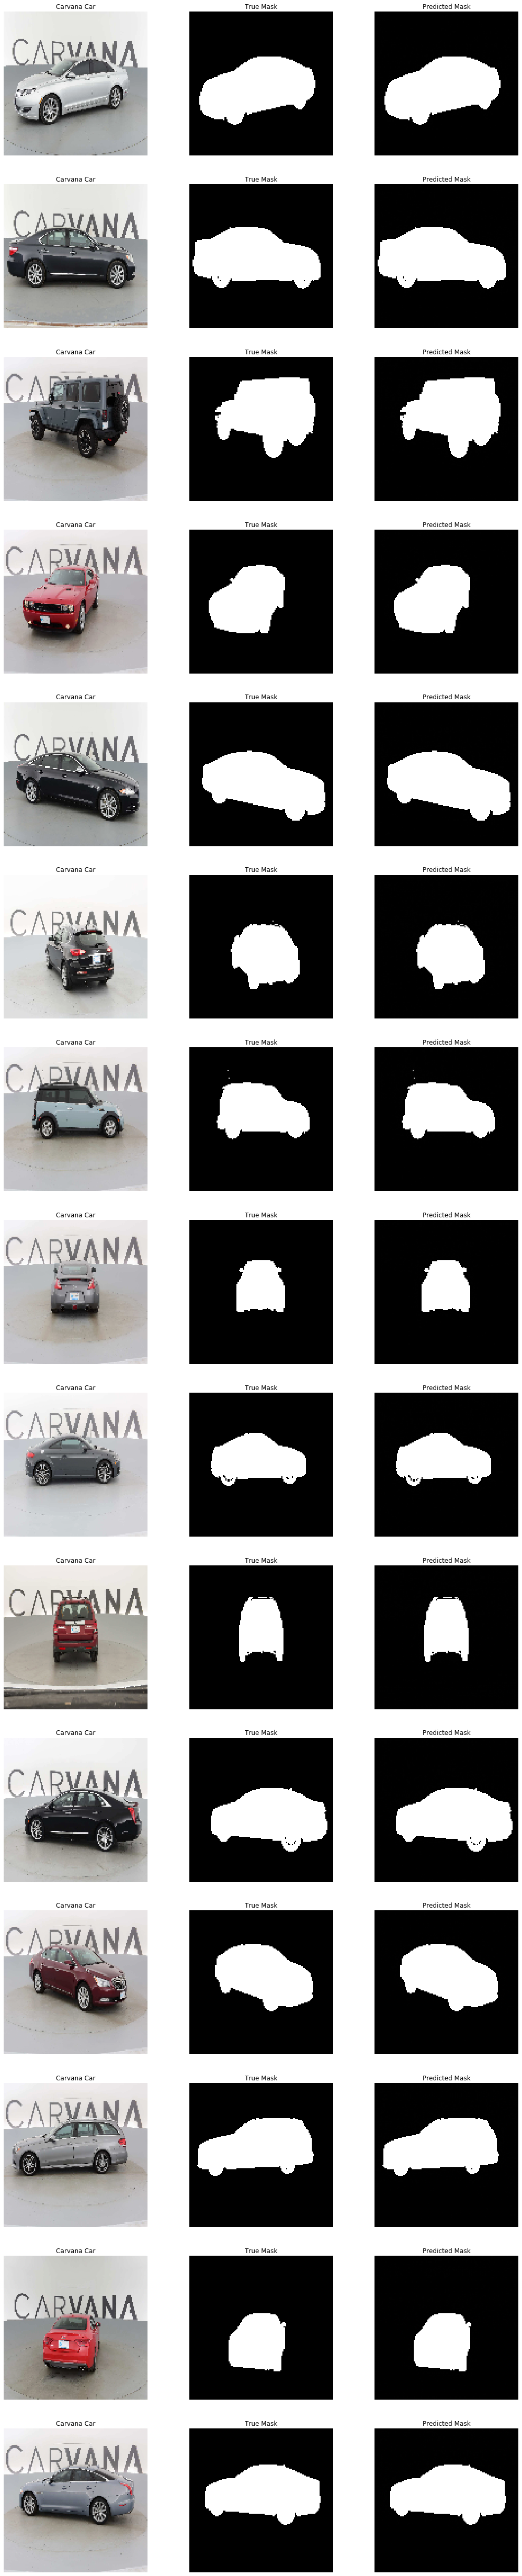

In [21]:
make_inference(img, masks, mask_preds, 15)